# AI4ALL 2018 Sessió 2
En aquesta sessió aprendrem a construir l'esquelet bàsic d'entrenament d'una xarxa neural, i a aprendre-la.

En primer lloc importem llibreries necessàries:

In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt # llibreria per a mostrar gràfics

Ara definim la xarxa neural que volem crear:

In [2]:
class Xarxa(torch.nn.Module): # Per a que ho reconegui, ha de ser un mòdul de pytorch
    def __init__(self, num_entrades, num_sortides, neurones):
        super().__init__() # Necessari per a que funcioni pytorch
        self.linear1 = torch.nn.Linear(num_entrades, neurones) # Afegim capa de neurones
        self.relu1 = torch.nn.ReLU() # Afegim no-linearitat
        self.linear2 = torch.nn.Linear(neurones, num_sortides) # Afegim capa de neurones
    
    def forward(self, dades): # Aquesta funció rep les dades i aplica les capes que hem creat en l'ordre que decidim
        resultat = self.linear1(dades)
        resultat = self.relu1(resultat) # cada capa s'aplica sobre la sortida de la capa anterior
        resultat = self.linear2(resultat)
        return resultat
        

Instanciem la xarxa i la funció d'error que volem minimitzar:

In [3]:
n_entrades = 2
n_sortides = 2
neurones = 4
xarxa = Xarxa(n_entrades, n_sortides, neurones)
f_error = torch.nn.CrossEntropyLoss() # CrossEntropy permet classificar

Escollim coeficient d'aprenentatge i instanciem l'optimitzador utilitzarem:

In [4]:
coefficient = 0.01
# Adam rep dos paràmetres principalment: 1. les connexions de la xarxa a optimitzar, 2. el coeficient d'aprenentatge
optimitzador = torch.optim.Adam(xarxa.parameters(), coefficient)

Carreguem les dades. En aquest cas crearem una base de dades aleatoria d'exemple. Les dades solen quedar representades com a una matriu on cada fila és un exemple, i cada columna, un atribut.

In [5]:
dades = 5 * torch.randn(1024, 2) # Mil exemples amb dos atributs per exemple amb desviació estàndard de 5
categoria = ((dades[:,0] > 1.33) * (dades[:, 0] < 5)).long() # tot el que hi ha a la dreta de 1.33 serà de la classe 1
categoria = categoria | ((dades[:,0] < -1.33) * (dades[:,0] > -5)).long() # tot el que hi ha a l'esquerra de -1.33 serà de la classe 1
print("Dades", dades)
print("Categoria", categoria)

Dades tensor([[ 2.9442, -1.0995],
        [-1.2711,  0.2278],
        [ 3.6553,  0.5569],
        ...,
        [-1.2087,  0.6571],
        [-7.3781, -9.3605],
        [-1.5397,  2.0725]])
Categoria tensor([1, 0, 1,  ..., 0, 0, 1])


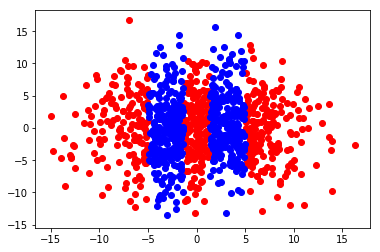

In [6]:
plt.scatter(dades[categoria == 0, 0].numpy(), dades[categoria == 0, 1].numpy(), color='r')
plt.scatter(dades[categoria == 1, 0].numpy(), dades[categoria == 1, 1].numpy(), color='b')

Definim una iteració d'entrenament:

In [7]:
def iteracio_entrenament(dades):
    error = 0
    percentatge_error = 0
    comptador = 0
    xarxa.train() # Avisem a la xarxa que la volem entrenar
    for batch_index in range(0, dades.size(0), 256): # Fem batchos de 256 valors
        optimitzador.zero_grad() # borrem dades sobre la iteració anterior (si es que n'havia)
        entrada = dades[batch_index:(batch_index + 256), :] # passem un batch de 256 files a la xarxa
        sortida = categoria[batch_index:(batch_index + 256)]
        prediccio = xarxa(entrada) 
        error_actual_ = f_error(prediccio, sortida)
        error_actual_.backward() # Diem a pytorch que minimitzi aquest valor d'error
        optimitzador.step() # L'optimitzador fa un pas en el descens de gradient

        classificacio = prediccio.max(1)[1] # Això ens retorna de les dues neurones de sortida, quina s'ha activat més
        percentatge_error += (classificacio == sortida).float().mean()
        error += error_actual_
        comptador += 1
    return error / comptador, percentatge_error / comptador

Definim iteració de test (simplement aplicar la xarxa sobre les dades, sense entrenar)

In [8]:
def iteracio_test(dades):
    #error = 0
    #percentatge_error = 0
    prediccions = []
    #comptador = 0
    xarxa.eval()
    with torch.no_grad(): # Avisem a torch que no cal que es guardi valors intermitjos per a calcular derivades
        for batch_index in range(0, dades.size(0), 256): # Fem batchos de 256 valors
            entrada = dades[batch_index:(batch_index + 256), :] # passem un batch de 256 files a la xarxa
            sortida = categoria[batch_index:(batch_index + 256)]
            prediccio = xarxa(entrada) 
            error_actual_ = f_error(prediccio, sortida)
            prediccions.append(prediccio.max(1)[1]) # Això ens retorna de les dues neurones de sortida, quina s'ha activat més
            #percentatge_error += (classificacio == sortida).float().mean()
            #error += error_actual_
            #comptador += 1
    return prediccions

Ara podem entrenar la xarxa per a que aprengui a classificar aquesta base de dades.

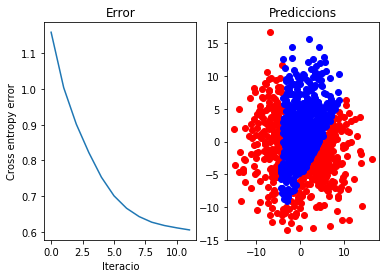

In [ ]:
error_actual = 100000000 # inicialitzem l'error actual a un valor molt alt
min_error = 0.5 # pararem quan l'error valgui això
historic_errors = []

from IPython import display # Cosa lletja per a que al mostrar quedi maco

while error_actual > min_error:
    valors_error = [] # Llista amb el valor de la funció d'error (per a poder mostrar grafic)
    error_actual, percentatge_error = iteracio_entrenament(dades)
    #print("Percent error batch: %.02f" %(100 - percentatge_error * 100))
    historic_errors.append(error_actual)
    prediccions = iteracio_test(dades)
    prediccions = torch.cat(prediccions, 0) # Convertim prediccions a llista de pytorch (abans era una llista de Python)
    
    # Funcions per a mostrar per pantalla (opcional)
    display.clear_output(wait=True)
    plt.clf()
    plt.subplot(1,2,1)
    plt.title("Error")
    plt.xlabel("Iteracio")
    plt.ylabel("Cross entropy error")
    plt.plot(historic_errors)

    plt.subplot(1,2,2)
    plt.title("Prediccions")    
    plt.scatter(dades[prediccions == 0, 0].numpy(), dades[prediccions == 0, 1].numpy(), color='r')
    plt.scatter(dades[prediccions == 1, 0].numpy(), dades[prediccions == 1, 1].numpy(), color='b')
    plt.show(False)
    
percentatge_error = (prediccions == sortida).float().mean()
print("Percent error dataset: %.02f" %(100 - percentatge_error * 100))

## Exercicis
1. Com afecta el número de neurones a l'aprenentatge?
2. Com afecta el coeficient d'aprenentatge?
3. Què passa si treieu la no-linearitat?
4. Canvieu l'optimitzador per SGD i observeu el comportament.
5. Què passa si afegiu capes?
6. Obteniu el mateix resultat en dues execucions? Per què?
7. Incrementeu la mida de la base de dades, creeu un subconjunt de validació i compareu l'error d'entrenament amb el de validació.
    7.1 Com afecten els paràmetres anteriors a incrementar o disminuir la diferència entre train i validació?